In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
#load datasets
am_df = pd.read_csv("data/american_stock.csv")
eu_df = pd.read_csv("data/european_index.csv")
rf_df = pd.read_csv("data/FEDFUNDS.csv")

In [22]:
am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
am_df["tte"] = am_df["exdate"] - am_df["date"]
am_df.head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,tte
0,101594,2015-01-02,AAPL 150102C100000,1,2015-01-02,20150102.0,C,100000,9.20,9.35,...,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN,0 days
1,101594,2015-01-02,AAPL 150102C101000,1,2015-01-02,20150102.0,C,101000,8.20,8.40,...,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN,0 days
2,101594,2015-01-02,AAPL 150102C102000,1,2015-01-02,20150102.0,C,102000,7.25,7.35,...,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN,0 days
3,101594,2015-01-02,AAPL 150102C103000,1,2015-01-02,20150102.0,C,103000,6.20,6.40,...,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN,0 days
4,101594,2015-01-02,AAPL 150102C104000,1,2015-01-02,20150102.0,C,104000,5.25,5.35,...,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN,0 days


In [23]:
eu_df["date"] = pd.to_datetime(eu_df["date"], format="%Y%m%d")
eu_df["exdate"] = pd.to_datetime(eu_df["exdate"], format="%Y%m%d")
eu_df["tte"] = eu_df["exdate"] - eu_df["date"]
eu_df.head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,tte
0,102480,2015-01-02,NDX 150109C3100000,1,2015-01-09,20141230.0,C,3100000,1124.9,1134.0,...,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN,7 days
1,102480,2015-01-02,NDX 150109C3125000,1,2015-01-09,NaN,C,3125000,1099.9,1109.0,...,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN,7 days
2,102480,2015-01-02,NDX 150109C3150000,1,2015-01-09,NaN,C,3150000,1074.9,1084.0,...,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN,7 days
3,102480,2015-01-02,NDX 150109C3175000,1,2015-01-09,NaN,C,3175000,1049.9,1059.0,...,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN,7 days
4,102480,2015-01-02,NDX 150109C3200000,1,2015-01-09,NaN,C,3200000,1024.9,1034.0,...,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN,7 days


In [12]:
rf_df.head()

,DATE,FEDFUNDS
0,2013-02-01,0.15
1,2013-03-01,0.14
2,2013-04-01,0.15
3,2013-05-01,0.11
4,2013-06-01,0.09


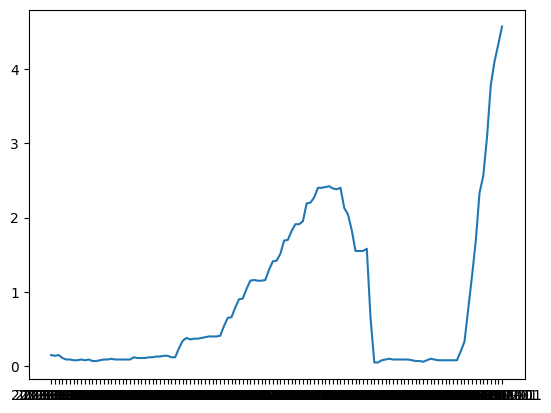

In [24]:
plt.plot(rf_df["DATE"], rf_df["FEDFUNDS"])

In [ ]:
def simple_european_binomial_model(dt, n_steps, underlying_price, strike, tte, call=True):
    return
